# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [75]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.sql import Window

# ML imports
from pyspark.ml.feature import Normalizer, StandardScaler, VectorAssembler
from pyspark.ml.classification import LogisticRegression , DecisionTreeClassifier, GBTClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator , BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

import datetime
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [76]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Data") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [77]:
#Load the sample data to do intial analysis 
path = "mini_sparkify_event_data.json"
user_log = spark.read.json(path)

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [78]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [79]:
user_log.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|            length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+------------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|            228108|286500|           278154|286500| 286500|     

In [80]:
# use Pandas for a better view , transpose so all the info is on the page and dont need to scroll righ 
df=user_log.toPandas()
df.head(5).transpose()

,0,1,2,3,4
artist,Martha Tilston,Five Iron Frenzy,Adam Lambert,Enigma,Daft Punk
auth,Logged In,Logged In,Logged In,Logged In,Logged In
firstName,Colin,Micah,Colin,Micah,Colin
gender,M,M,M,M,M
itemInSession,50,79,51,80,52
lastName,Freeman,Long,Freeman,Long,Freeman
length,277.89,236.094,282.827,262.713,223.608
level,paid,free,paid,free,paid
location,"Bakersfield, CA","Boston-Cambridge-Newton, MA-NH","Bakersfield, CA","Boston-Cambridge-Newton, MA-NH","Bakersfield, CA"
method,PUT,PUT,PUT,PUT,PUT


In [81]:
#again using Pandas dataframe to get more info 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286500 entries, 0 to 286499
Data columns (total 18 columns):
artist           228108 non-null object
auth             286500 non-null object
firstName        278154 non-null object
gender           278154 non-null object
itemInSession    286500 non-null int64
lastName         278154 non-null object
length           228108 non-null float64
level            286500 non-null object
location         278154 non-null object
method           286500 non-null object
page             286500 non-null object
registration     278154 non-null float64
sessionId        286500 non-null int64
song             228108 non-null object
status           286500 non-null int64
ts               286500 non-null int64
userAgent        278154 non-null object
userId           286500 non-null object
dtypes: float64(2), int64(4), object(12)
memory usage: 39.3+ MB


In [82]:
#number of unique users using Pandas 
df["userId"].nunique()

226

In [83]:
#number of unique users using pyspark 
user_log.select('userId').distinct().count()

226

In [84]:
#looked at the users userIds - noted the bank user id 
user_log.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [85]:
#remove the blank user id data 
user_log_clean = user_log.filter(user_log["userId"] != "")

In [86]:
#confirm the number of unique users after dropping the blanks 
user_log_clean.select('userId').distinct().count()

225

In [87]:
user_log_clean.count()

278154

In [88]:
user_log_clean.select("level").dropDuplicates().sort("level").show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [89]:
user_log_clean.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [90]:
user_log_clean.groupBy('page').count().sort('count',ascending=False).show()

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Home| 10082|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|            Settings|  1514|
|                Help|  1454|
|             Upgrade|   499|
|               About|   495|
|       Save Settings|   310|
|               Error|   252|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+--------------------+------+



In [91]:
user_log_clean.groupBy('status').count().sort('count',ascending=False).show()

+------+------+
|status| count|
+------+------+
|   200|254718|
|   307| 23184|
|   404|   252|
+------+------+



In [92]:
user_log_clean.groupBy('auth').count().sort('count',ascending=False).show()

+---------+------+
|     auth| count|
+---------+------+
|Logged In|278102|
|Cancelled|    52|
+---------+------+



## Define Churn and Downgrade 

In [93]:
#user defined function to flag Churn
flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [94]:
#user defined function to flag Downgrade
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [95]:
#create a new column 'churn' using the udf above to input 1 if 'Cancellation Confirmation' else 0 for other 
user_log_clean = user_log_clean.withColumn("churn", flag_churn_event("page"))

In [96]:
#create a new column 'downgrade' using the udf above to input 1 if 'Submit Downgrade' else 0 for other 
user_log_clean = user_log_clean.withColumn("downgrade", flag_downgrade_event("page"))

In [97]:
user_log_clean.count()

278154

In [98]:
#used udacity coarse work example to help structure this 
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [99]:
#dropped looking at Downgrade as single user could downgrade multiple times 
user_log_clean = user_log_clean.withColumn("downgrade", Fsum("downgrade").over(windowval))

In [100]:
user_log_clean = user_log_clean.withColumn("churn", Fsum("churn").over(windowval))

In [101]:
user_log_clean.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: long (nullable = true)
 |-- downgrade: long (nullable = true)



In [102]:
# show the split of the 225 unique user for churned or not churned - only 52 users have churned 
user_log_clean.select(['userId','churn']).distinct().groupBy('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



In [103]:
#descided to drop the downgrde option because of multiple downgrades 
#user_log_clean.groupby(['downgrade']).count().show()
user_log_clean.select(['userId','downgrade']).distinct().groupBy('downgrade').count().show()

+---------+-----+
|downgrade|count|
+---------+-----+
|        0|  225|
|        1|   49|
|        3|    2|
|        2|   12|
+---------+-----+



In [104]:
#view showing if user has churned or not 
user_log_clean.select(['userId', 'churn']).dropDuplicates().show(10)

+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
+------+-----+
only showing top 10 rows



## Data Exploration

In [105]:
#User defined function to get the hour of the day from ts (timestamp) column 
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [106]:
get_timestamp = udf(lambda x : datetime.datetime.fromtimestamp(x/ 1000.0).strftime("%d-%m-%Y %H:%M:%S"))

In [107]:
user_log_clean = user_log_clean.withColumn("hour", get_hour(user_log_clean.ts))

In [108]:
user_log_clean = user_log_clean.withColumn("datetime", get_timestamp(user_log_clean.registration))

In [109]:
user_log_clean = user_log_clean.withColumn("reg_date", get_timestamp(user_log_clean.ts))

In [110]:
user_log_clean.head()

Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, downgrade=0, hour='18', datetime='27-09-2018 03:45:40', reg_date='21-11-2018 18:12:32')

In [111]:
songs_in_hour = user_log_clean.filter(user_log_clean.page == "NextSong").groupby('hour','churn').count().orderBy(user_log_clean.hour.cast("float"))

In [112]:
#songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

In [133]:
#plt.plot(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
#plt.xlim(-1, 23);
#plt.ylim(0.9 * min(songs_in_hour_pd["count"]), 1.1 * max(songs_in_hour_pd["count"]))
#plt.xlabel("Hour")
#plt.ylabel("Songs played");

In [114]:
songs_in_hour.show(25)

+----+-----+-----+
|hour|churn|count|
+----+-----+-----+
|   0|    1| 1564|
|   0|    0| 7763|
|   1|    0| 7337|
|   1|    1| 1558|
|   2|    0| 7000|
|   2|    1| 1339|
|   3|    0| 7009|
|   3|    1| 1350|
|   4|    1| 1295|
|   4|    0| 6934|
|   5|    0| 6779|
|   5|    1| 1200|
|   6|    0| 6906|
|   6|    1| 1208|
|   7|    0| 6905|
|   7|    1| 1214|
|   8|    1| 1222|
|   8|    0| 7003|
|   9|    0| 7098|
|   9|    1| 1261|
|  10|    1| 1294|
|  10|    0| 7308|
|  11|    0| 7300|
|  11|    1| 1353|
|  12|    0| 7877|
+----+-----+-----+
only showing top 25 rows



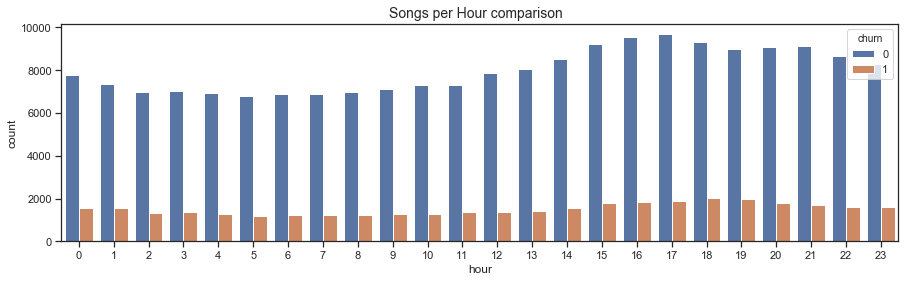

In [145]:
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)
sn.set(style="ticks", color_codes=True)
plt.figure(figsize=(15, 4))
plt.title("Songs per Hour comparison  ", fontsize=14)
sn.barplot(x="hour", y="count", hue="churn", data=songs_in_hour_pd);

In [147]:
average_songs_in_hour = user_log_clean.filter(user_log_clean.page == "NextSong").groupby('hour','churn').mean().orderBy(user_log_clean.hour.cast("float"))

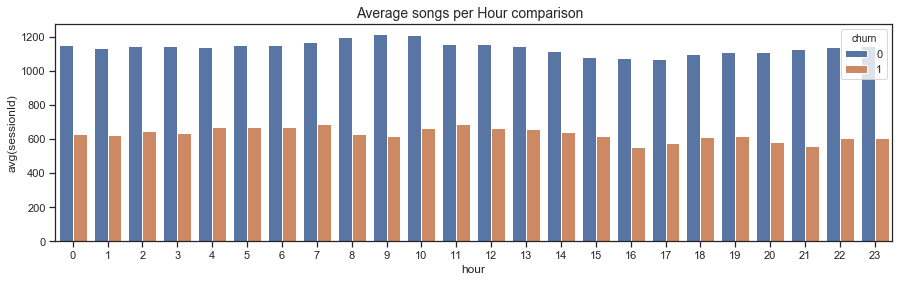

In [148]:
average_songs_in_hour = average_songs_in_hour.toPandas()
average_songs_in_hour.hour = pd.to_numeric(average_songs_in_hour.hour)
sn.set(style="ticks", color_codes=True)
plt.figure(figsize=(15, 4))
plt.title("Average songs per Hour comparison  ", fontsize=14)
sn.barplot(x="hour", y="avg(sessionId)", hue="churn", data=average_songs_in_hour);

In [116]:
#User gender distribution 
user_log_clean.select(['userId','gender']).distinct().groupBy('gender').count().show()

+------+-----+
|gender|count|
+------+-----+
|     F|  104|
|     M|  121|
+------+-----+



In [117]:
#Gender Churn 
user_log_clean.dropDuplicates(['userId', 'gender']).groupby(['churn', 'gender']).count().show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|    0|     F|   84|
|    1|     M|   32|
|    1|     F|   20|
|    0|     M|   89|
+-----+------+-----+



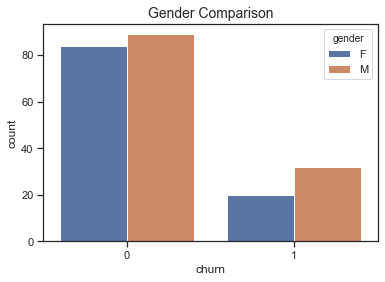

In [132]:
gender_plt = user_log_clean.dropDuplicates(['userId', 'gender']).groupby(['churn','gender']).count().toPandas()
sn.set(style="ticks", color_codes=True)
plt.title("Gender Comparison", fontsize=14)
sn.barplot(x="churn", y="count", hue="gender", data=gender_plt);

In [119]:
# Wont add up to 225 because of the mulitple upgrades and downgrades 
user_log_clean.dropDuplicates(['userId', 'churn','level']).groupby(['level','churn']).count().show()

+-----+-----+-----+
|level|churn|count|
+-----+-----+-----+
| free|    0|  149|
| paid|    0|  129|
| free|    1|   46|
| paid|    1|   36|
+-----+-----+-----+



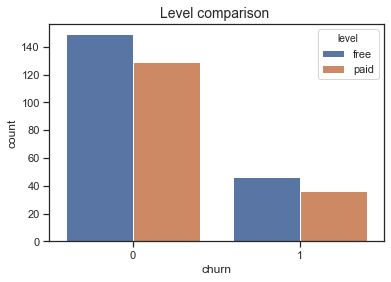

In [131]:
level_plt = user_log_clean.dropDuplicates(['userId', 'churn', 'level']).groupby(['level','churn']).count().toPandas()
sn.set(style="ticks", color_codes=True)
plt.title("Level comparison ", fontsize=14)
sn.barplot(x="churn", y="count", hue="level", data=level_plt);

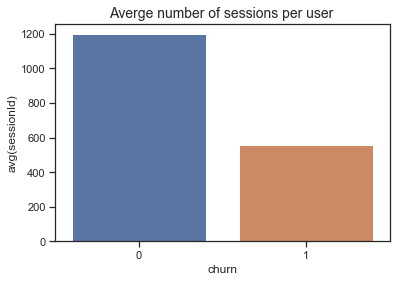

In [129]:
# the averge number of sessions for churned vs non-churned 
sessions = user_log_clean.select(['sessionId', 'churn']).distinct().groupBy('churn').mean().sort('churn').toPandas()
sn.set(style="ticks", color_codes=True)
plt.title("Averge number of sessions per user ", fontsize=14)
sn.barplot(x="churn", y="avg(sessionId)", data=sessions);

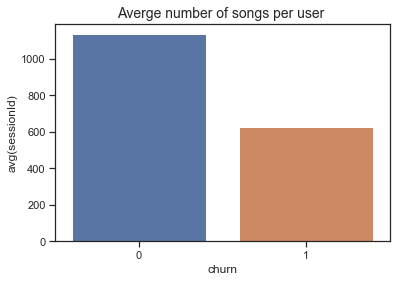

In [130]:
# average number of songs pper user for churned vs non-churned 
songs_churn = user_log_clean.filter(user_log_clean.page == "NextSong").groupby(user_log_clean.churn).mean().orderBy(user_log_clean.churn.cast("float")).toPandas()
sn.set(style="ticks", color_codes=True)
plt.title("Averge number of songs per user ", fontsize=14)
sn.barplot(x="churn", y="avg(sessionId)", data=songs_churn);

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Features and Label definition 

## Label 

1) Churn 

## Features 

1) Song count per user 
2) Like count per user
3) dis-likes per user 
4) number of playlists 
5) number of friends 
6) number of sessions
7) number of erors experienced
8) active time 
9) gender 
10 account type i.e. paid or free       

In [49]:
#start with just userId and churn status - this will be the label 
churn = user_log_clean.select(['userId', 'churn']).dropDuplicates().orderBy(user_log_clean.userId)
churn.show(5)

+------+-----+
|userId|churn|
+------+-----+
|    10|    0|
|   100|    0|
|100001|    1|
|100002|    0|
|100003|    1|
+------+-----+
only showing top 5 rows



In [48]:
#print schema 
user_log_clean.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: long (nullable = true)
 |-- downgrade: integer (nullable = true)
 |-- hour: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- reg_date: string (nullable = true)



In [50]:
#view of availble data for feature engineering 
df_clean=user_log_clean.toPandas()
df.head(5).transpose()

,0,1,2,3,4
artist,Martha Tilston,Five Iron Frenzy,Adam Lambert,Enigma,Daft Punk
auth,Logged In,Logged In,Logged In,Logged In,Logged In
firstName,Colin,Micah,Colin,Micah,Colin
gender,M,M,M,M,M
itemInSession,50,79,51,80,52
lastName,Freeman,Long,Freeman,Long,Freeman
length,277.89,236.094,282.827,262.713,223.608
level,paid,free,paid,free,paid
location,"Bakersfield, CA","Boston-Cambridge-Newton, MA-NH","Bakersfield, CA","Boston-Cambridge-Newton, MA-NH","Bakersfield, CA"
method,PUT,PUT,PUT,PUT,PUT


In [51]:
#look closer at the page column catagories to see what could be used for feature engineering 
user_log_clean.groupBy('page').count().sort('count',ascending=False).show()

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Home| 10082|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|            Settings|  1514|
|                Help|  1454|
|             Upgrade|   499|
|               About|   495|
|       Save Settings|   310|
|               Error|   252|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+--------------------+------+



In [52]:
#song count per user 
song_count = user_log_clean.filter(user_log_clean.page == "NextSong").groupby(user_log_clean.userId).count().withColumnRenamed('count', 'song_count').orderBy(user_log_clean.userId)
song_count.show(5)

+------+----------+
|userId|song_count|
+------+----------+
|    10|       673|
|   100|      2682|
|100001|       133|
|100002|       195|
|100003|        51|
+------+----------+
only showing top 5 rows



In [53]:
#likes per user 
like_count = user_log_clean.filter(user_log_clean.page == "Thumbs Up").groupby(user_log_clean.userId).count().withColumnRenamed('count', 'thumbs_up').orderBy(user_log_clean.userId)
like_count.show(5)

+------+---------+
|userId|thumbs_up|
+------+---------+
|    10|       37|
|   100|      148|
|100001|        8|
|100002|        5|
|100003|        3|
+------+---------+
only showing top 5 rows



In [54]:
#dislikes per user 
dislike_count = user_log_clean.filter(user_log_clean.page == "Thumbs Down").groupby(user_log_clean.userId).count().withColumnRenamed('count', 'thumbs_down').orderBy(user_log_clean.userId)
dislike_count.show(5)
dislike_count.count()

+------+-----------+
|userId|thumbs_down|
+------+-----------+
|    10|          4|
|   100|         27|
|100001|          2|
|100004|         11|
|100005|          3|
+------+-----------+
only showing top 5 rows



203

In [55]:
#playlists per user 
playlist_count = user_log_clean.filter(user_log_clean.page == "Add to Playlist").groupby(user_log_clean.userId).count().withColumnRenamed('count', 'playlist_count').orderBy(user_log_clean.userId)
playlist_count.show(5)

+------+--------------+
|userId|playlist_count|
+------+--------------+
|    10|             9|
|   100|            61|
|100001|             3|
|100002|             5|
|100003|             2|
+------+--------------+
only showing top 5 rows



In [56]:
#friend count per user 
friend_count = user_log_clean.filter(user_log_clean.page == "Add Friend").groupby(user_log_clean.userId).count().withColumnRenamed('count', 'friend_count').orderBy(user_log_clean.userId)
friend_count.show(5)

+------+------------+
|userId|friend_count|
+------+------------+
|    10|          12|
|   100|          49|
|100001|           2|
|100002|           1|
|100004|          19|
+------+------------+
only showing top 5 rows



In [57]:
#sessions count per user 
sessions_count = user_log_clean.select('userId', 'sessionId').dropDuplicates().groupby('userId').count().withColumnRenamed('count', 'session_count').orderBy(user_log_clean.userId)
sessions_count.show(5)

+------+-------------+
|userId|session_count|
+------+-------------+
|    10|            6|
|   100|           35|
|100001|            4|
|100002|            4|
|100003|            2|
+------+-------------+
only showing top 5 rows



In [58]:
#Error count per user 
error_count = user_log_clean.filter(user_log_clean.page == "Error").groupby(user_log_clean.userId).count().withColumnRenamed('count', 'error_count').orderBy(user_log_clean.userId)
error_count.show(5)

+------+-----------+
|userId|error_count|
+------+-----------+
|   100|          3|
|100001|          1|
|100004|          2|
|100013|          2|
|100015|          1|
+------+-----------+
only showing top 5 rows



In [59]:
#numbers of days active per user
last_active =  user_log_clean.groupby('userId').max('ts')
first_Active = user_log_clean.groupby('userId').min('ts')
combined_dates = last_active.join(first_Active, on=['userId'], how='inner')
combined_dates = combined_dates.withColumn("active", ((col("max(ts)") - col("min(ts)"))/86400000).cast(IntegerType()))
active = combined_dates.drop("max(ts)" ,"min(ts)" ).orderBy('userId')
active.show(5)

+------+------+
|userId|active|
+------+------+
|    10|    42|
|   100|    58|
|100001|     1|
|100002|    55|
|100003|     2|
+------+------+
only showing top 5 rows



In [60]:
#create dummy variables script 
#https://stackoverflow.com/questions/35879372/pyspark-matrix-with-dummy-variables

def create_dummy (col):
    
    '''
    converts column into a number of new columns with numneric 1 if varible present in row else 0 
    col: the column name
    return a dataframe with dummy variable 
    '''
    categories = user_log_clean.select(col).distinct().rdd.flatMap(lambda x: x).collect()
    exprs = [F.when(F.col(col) == category, 1).otherwise(0).alias(category)
         for category in categories]
    
    dummy = user_log_clean.select("userId", *exprs).dropDuplicates()
    
    return dummy

In [61]:
#using create_dummy above add dummy variables for M or F 
gender = create_dummy('gender')
gender.show(5)
gender.count()

+------+---+---+
|userId|  F|  M|
+------+---+---+
|    52|  1|  0|
|    43|  1|  0|
|    57|  0|  1|
|    83|  0|  1|
|   132|  1|  0|
+------+---+---+
only showing top 5 rows



225

In [62]:
#using create_dummy above add dummy variables for free or paid
level = create_dummy('level').dropDuplicates(['userId'])
level.show(5)
level.count()

+------+----+----+
|userId|free|paid|
+------+----+----+
|200002|   1|   0|
|100010|   1|   0|
|   125|   1|   0|
|   124|   0|   1|
|     7|   1|   0|
+------+----+----+
only showing top 5 rows



225

In [63]:
#combining dataframes to create the features dataframe 
features = churn
features = features.join(song_count ,'userId')
features.show(5)
features.count()

+------+-----+----------+
|userId|churn|song_count|
+------+-----+----------+
|100010|    0|       275|
|200002|    0|       387|
|   125|    1|         8|
|   124|    0|      4079|
|    51|    1|      2111|
+------+-----+----------+
only showing top 5 rows



225

In [64]:
features = features.join(like_count , 'userId' , how = 'left')
features.show(5)
features.count()

+------+-----+----------+---------+
|userId|churn|song_count|thumbs_up|
+------+-----+----------+---------+
|100010|    0|       275|       17|
|200002|    0|       387|       21|
|   125|    1|         8|     null|
|   124|    0|      4079|      171|
|    51|    1|      2111|      100|
+------+-----+----------+---------+
only showing top 5 rows



225

In [65]:
features = features.join(dislike_count, 'userId', how='left')
features.show(5)
features.count()

+------+-----+----------+---------+-----------+
|userId|churn|song_count|thumbs_up|thumbs_down|
+------+-----+----------+---------+-----------+
|100010|    0|       275|       17|          5|
|200002|    0|       387|       21|          6|
|   125|    1|         8|     null|       null|
|   124|    0|      4079|      171|         41|
|    51|    1|      2111|      100|         21|
+------+-----+----------+---------+-----------+
only showing top 5 rows



225

In [66]:
features = features.join(playlist_count, 'userId', how='left')
features.show(5)
features.count()

+------+-----+----------+---------+-----------+--------------+
|userId|churn|song_count|thumbs_up|thumbs_down|playlist_count|
+------+-----+----------+---------+-----------+--------------+
|100010|    0|       275|       17|          5|             7|
|200002|    0|       387|       21|          6|             8|
|   125|    1|         8|     null|       null|          null|
|   124|    0|      4079|      171|         41|           118|
|    51|    1|      2111|      100|         21|            52|
+------+-----+----------+---------+-----------+--------------+
only showing top 5 rows



225

In [67]:
features = features.join(friend_count, 'userId', how='left')
features.show(5)
features.count()

+------+-----+----------+---------+-----------+--------------+------------+
|userId|churn|song_count|thumbs_up|thumbs_down|playlist_count|friend_count|
+------+-----+----------+---------+-----------+--------------+------------+
|100010|    0|       275|       17|          5|             7|           4|
|200002|    0|       387|       21|          6|             8|           4|
|   125|    1|         8|     null|       null|          null|        null|
|   124|    0|      4079|      171|         41|           118|          74|
|    51|    1|      2111|      100|         21|            52|          28|
+------+-----+----------+---------+-----------+--------------+------------+
only showing top 5 rows



225

In [68]:
features = features.join(sessions_count, 'userId', how='left')
features.show(5)
features.count()

+------+-----+----------+---------+-----------+--------------+------------+-------------+
|userId|churn|song_count|thumbs_up|thumbs_down|playlist_count|friend_count|session_count|
+------+-----+----------+---------+-----------+--------------+------------+-------------+
|100010|    0|       275|       17|          5|             7|           4|            7|
|200002|    0|       387|       21|          6|             8|           4|            6|
|   125|    1|         8|     null|       null|          null|        null|            1|
|   124|    0|      4079|      171|         41|           118|          74|           29|
|    51|    1|      2111|      100|         21|            52|          28|           10|
+------+-----+----------+---------+-----------+--------------+------------+-------------+
only showing top 5 rows



225

In [69]:
features = features.join(error_count, 'userId' , how='left')
features.show(5)
features.count()

+------+-----+----------+---------+-----------+--------------+------------+-------------+-----------+
|userId|churn|song_count|thumbs_up|thumbs_down|playlist_count|friend_count|session_count|error_count|
+------+-----+----------+---------+-----------+--------------+------------+-------------+-----------+
|100010|    0|       275|       17|          5|             7|           4|            7|       null|
|200002|    0|       387|       21|          6|             8|           4|            6|       null|
|   125|    1|         8|     null|       null|          null|        null|            1|       null|
|   124|    0|      4079|      171|         41|           118|          74|           29|          6|
|    51|    1|      2111|      100|         21|            52|          28|           10|          1|
+------+-----+----------+---------+-----------+--------------+------------+-------------+-----------+
only showing top 5 rows



225

In [70]:
features = features.join(active, 'userId', how='left')
features.show(5)
features.count()

+------+-----+----------+---------+-----------+--------------+------------+-------------+-----------+------+
|userId|churn|song_count|thumbs_up|thumbs_down|playlist_count|friend_count|session_count|error_count|active|
+------+-----+----------+---------+-----------+--------------+------------+-------------+-----------+------+
|100010|    0|       275|       17|          5|             7|           4|            7|       null|    44|
|200002|    0|       387|       21|          6|             8|           4|            6|       null|    45|
|   125|    1|         8|     null|       null|          null|        null|            1|       null|     0|
|   124|    0|      4079|      171|         41|           118|          74|           29|          6|    59|
|    51|    1|      2111|      100|         21|            52|          28|           10|          1|    15|
+------+-----+----------+---------+-----------+--------------+------------+-------------+-----------+------+
only showing top 5 

225

In [71]:
features = features.join(gender, 'userId', how='left')
features.show(5)
features.count()

+------+-----+----------+---------+-----------+--------------+------------+-------------+-----------+------+---+---+
|userId|churn|song_count|thumbs_up|thumbs_down|playlist_count|friend_count|session_count|error_count|active|  F|  M|
+------+-----+----------+---------+-----------+--------------+------------+-------------+-----------+------+---+---+
|100010|    0|       275|       17|          5|             7|           4|            7|       null|    44|  1|  0|
|200002|    0|       387|       21|          6|             8|           4|            6|       null|    45|  0|  1|
|   125|    1|         8|     null|       null|          null|        null|            1|       null|     0|  0|  1|
|   124|    0|      4079|      171|         41|           118|          74|           29|          6|    59|  1|  0|
|    51|    1|      2111|      100|         21|            52|          28|           10|          1|    15|  0|  1|
+------+-----+----------+---------+-----------+--------------+--

225

In [72]:
features = features.join(level, 'userId', how='left')
features.show(5)
features.count()

+------+-----+----------+---------+-----------+--------------+------------+-------------+-----------+------+---+---+----+----+
|userId|churn|song_count|thumbs_up|thumbs_down|playlist_count|friend_count|session_count|error_count|active|  F|  M|free|paid|
+------+-----+----------+---------+-----------+--------------+------------+-------------+-----------+------+---+---+----+----+
|100010|    0|       275|       17|          5|             7|           4|            7|       null|    44|  1|  0|   1|   0|
|200002|    0|       387|       21|          6|             8|           4|            6|       null|    45|  0|  1|   1|   0|
|   125|    1|         8|     null|       null|          null|        null|            1|       null|     0|  0|  1|   1|   0|
|   124|    0|      4079|      171|         41|           118|          74|           29|          6|    59|  1|  0|   0|   1|
|    51|    1|      2111|      100|         21|            52|          28|           10|          1|    15|  0

225

In [73]:
#which columns have null values 
features.toPandas().isnull().sum()

userId              0
churn               0
song_count          0
thumbs_up           5
thumbs_down        22
playlist_count     10
friend_count       19
session_count       0
error_count       108
active              0
F                   0
M                   0
free                0
paid                0
dtype: int64

In [74]:
#aassumption is if null then should be a a zero value 
#replace null values with zero 
features = features.na.fill(0)

In [75]:
#validate nulls have been removed 
features.toPandas().isnull().sum()

userId            0
churn             0
song_count        0
thumbs_up         0
thumbs_down       0
playlist_count    0
friend_count      0
session_count     0
error_count       0
active            0
F                 0
M                 0
free              0
paid              0
dtype: int64

In [76]:
#drop the userId from the data frame as not needed for the modeling 
features = features.drop("userId")

In [77]:
features.printSchema()

root
 |-- churn: long (nullable = true)
 |-- song_count: long (nullable = false)
 |-- thumbs_up: long (nullable = true)
 |-- thumbs_down: long (nullable = true)
 |-- playlist_count: long (nullable = true)
 |-- friend_count: long (nullable = true)
 |-- session_count: long (nullable = true)
 |-- error_count: long (nullable = true)
 |-- active: integer (nullable = true)
 |-- F: integer (nullable = true)
 |-- M: integer (nullable = true)
 |-- free: integer (nullable = true)
 |-- paid: integer (nullable = true)



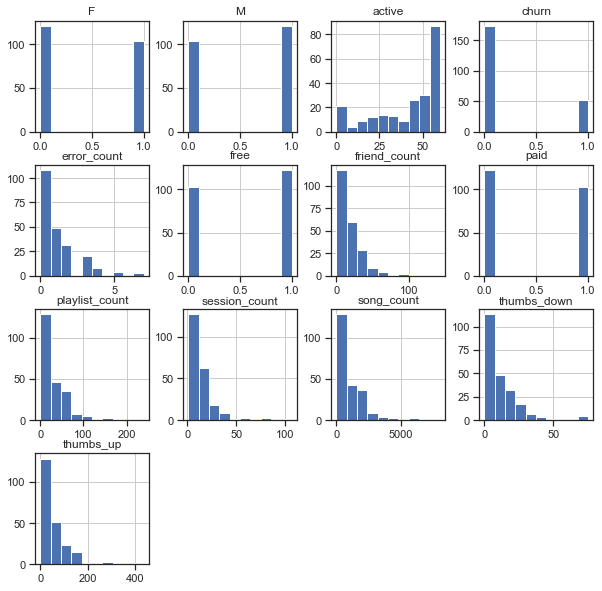

In [78]:
#look at the histograms for features to see if any obvious anomalies 
features.toPandas().hist(figsize = (10,10));

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [79]:
#Feature Column
numericCols = features.columns[1:]
print(numericCols)

['song_count', 'thumbs_up', 'thumbs_down', 'playlist_count', 'friend_count', 'session_count', 'error_count', 'active', 'F', 'M', 'free', 'paid']


In [80]:
# Transform all features into a vector using VectorAssembler
features_vector = VectorAssembler(inputCols=numericCols, outputCol='features')
data = features_vector.transform(features)
data.show(5)

+-----+----------+---------+-----------+--------------+------------+-------------+-----------+------+---+---+----+----+--------------------+
|churn|song_count|thumbs_up|thumbs_down|playlist_count|friend_count|session_count|error_count|active|  F|  M|free|paid|            features|
+-----+----------+---------+-----------+--------------+------------+-------------+-----------+------+---+---+----+----+--------------------+
|    0|       275|       17|          5|             7|           4|            7|          0|    44|  1|  0|   1|   0|[275.0,17.0,5.0,7...|
|    0|       387|       21|          6|             8|           4|            6|          0|    45|  0|  1|   1|   0|[387.0,21.0,6.0,8...|
|    1|         8|        0|          0|             0|           0|            1|          0|     0|  0|  1|   1|   0|(12,[0,5,9,10],[8...|
|    0|      4079|      171|         41|           118|          74|           29|          6|    59|  1|  0|   0|   1|[4079.0,171.0,41....|
|    1|      

In [81]:
#Scale the transformed vector above 
scale_feature = StandardScaler(withMean=True, withStd=True, inputCol='features', outputCol='scaled_features')
features_scaler_fit = scale_feature.fit(data)
scaled = features_scaler_fit.transform(data)
scaled.show(5)

+-----+----------+---------+-----------+--------------+------------+-------------+-----------+------+---+---+----+----+--------------------+--------------------+
|churn|song_count|thumbs_up|thumbs_down|playlist_count|friend_count|session_count|error_count|active|  F|  M|free|paid|            features|     scaled_features|
+-----+----------+---------+-----------+--------------+------------+-------------+-----------+------+---+---+----+----+--------------------+--------------------+
|    0|       275|       17|          5|             7|           4|            7|          0|    44|  1|  0|   1|   0|[275.0,17.0,5.0,7...|[-0.6686330842440...|
|    0|       387|       21|          6|             8|           4|            6|          0|    45|  0|  1|   1|   0|[387.0,21.0,6.0,8...|[-0.5672720204182...|
|    1|         8|        0|          0|             0|           0|            1|          0|     0|  0|  1|   1|   0|(12,[0,5,9,10],[8...|[-0.9102706203287...|
|    0|      4079|      171|

In [82]:
#check vector and scaled have been added  
scaled.printSchema()

root
 |-- churn: long (nullable = true)
 |-- song_count: long (nullable = false)
 |-- thumbs_up: long (nullable = true)
 |-- thumbs_down: long (nullable = true)
 |-- playlist_count: long (nullable = true)
 |-- friend_count: long (nullable = true)
 |-- session_count: long (nullable = true)
 |-- error_count: long (nullable = true)
 |-- active: integer (nullable = true)
 |-- F: integer (nullable = true)
 |-- M: integer (nullable = true)
 |-- free: integer (nullable = true)
 |-- paid: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaled_features: vector (nullable = true)



In [83]:
#create a new dataframe with label and features
mldata = scaled.select(col("churn").alias("label"), col("scaled_features").alias("features"))
mldata.show(5)
mldata.count()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[-0.6686330842440...|
|    0|[-0.5672720204182...|
|    1|[-0.9102706203287...|
|    0|[2.77402304783854...|
|    1|[0.99296435489991...|
+-----+--------------------+
only showing top 5 rows



225

In [84]:
# split data into train , test and validate 
#train, rest = mldata.randomSplit([0.7, 0.3], seed=41)
#validate, test  = rest.randomSplit([0.5, 0.5], seed=41)

In [ ]:
# split data into train and test 
train, test = mldata.randomSplit([0.7, 0.3], seed=41)

# Create a baseline to use to evaluate model performance 

There is an inbalance with the Label values i.e. far more 0's (76%) than 1's(24%)

In [85]:
from pyspark.sql.functions import rand , lit , when

In [86]:
#create a baseline dataframe to test 
baseline = mldata
baseline.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[-0.6686330842440...|
|    0|[-0.5672720204182...|
|    1|[-0.9102706203287...|
|    0|[2.77402304783854...|
|    1|[0.99296435489991...|
+-----+--------------------+
only showing top 5 rows



In [87]:
#view data 
baseline.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



In [88]:
#add column with all 0's 
baseline = baseline.withColumn("zeros", lit(0))
baseline.show(5)

+-----+--------------------+-----+
|label|            features|zeros|
+-----+--------------------+-----+
|    0|[-0.6686330842440...|    0|
|    0|[-0.5672720204182...|    0|
|    1|[-0.9102706203287...|    0|
|    0|[2.77402304783854...|    0|
|    1|[0.99296435489991...|    0|
+-----+--------------------+-----+
only showing top 5 rows



In [89]:
#add column with random 1's and 0's 
baseline = baseline.withColumn('random', when(rand() > 0.5, 1).otherwise(0))
baseline.show(5)

+-----+--------------------+-----+------+
|label|            features|zeros|random|
+-----+--------------------+-----+------+
|    0|[-0.6686330842440...|    0|     0|
|    0|[-0.5672720204182...|    0|     1|
|    1|[-0.9102706203287...|    0|     0|
|    0|[2.77402304783854...|    0|     0|
|    1|[0.99296435489991...|    0|     1|
+-----+--------------------+-----+------+
only showing top 5 rows



In [90]:
#compare zero column to label data
baseline.withColumn('zero_flag', F.when(col('zeros') == col('label'),1).otherwise(0)).groupBy('zero_flag').count().show()

+---------+-----+
|zero_flag|count|
+---------+-----+
|        1|  173|
|        0|   52|
+---------+-----+



In [91]:
#compare random with label data 
baseline.withColumn('rand_flag', F.when(col('random') == col('label'),1).otherwise(0)).groupBy('rand_flag').count().show()

+---------+-----+
|rand_flag|count|
+---------+-----+
|        1|  124|
|        0|  101|
+---------+-----+



Random 0's & 1's produces 55% correct answers
while all zeros prodduces 77% correct answers because the data is not balanced 

# Popular algorithms that can be used for binary classification include:

Logistic Regression ,
k-Nearest Neighbors , 
Decision Trees , 
Support Vector Machine , 
Naive Bayes and  
Random Forest . 

# Logistic Regression

In [119]:
#using model standard parameters 
lr = LogisticRegression(labelCol="label" , featuresCol= "features")
model_lr=lr.fit(train)
predictions_lr = model_lr.transform(test)

In [131]:
predictions_lr.show(5)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|[0.81467748370636...|[2.02474740134590...|[0.88337100896088...|       0.0|
|    0|[-0.1754029075918...|[0.97808953552371...|[0.72672897399882...|       0.0|
|    0|[0.82734761668458...|[3.14521696500398...|[0.95871984267452...|       0.0|
|    1|[-0.7093585116740...|[2.47440274911323...|[0.92232776162175...|       0.0|
|    0|[-0.7229336541507...|[3.06264651282927...|[0.95532538313558...|       0.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [122]:
print(model_lr)

LogisticRegressionModel: uid = LogisticRegression_8ce7cd1e6e3e, numClasses = 2, numFeatures = 12


In [123]:
predictions_lr.select("prediction", "label").show(5)

+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    1|
|       0.0|    0|
+----------+-----+
only showing top 5 rows



In [135]:
predictions_lr.groupBy('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|    6|
|    0|       1.0|    4|
|    0|       0.0|   52|
|    1|       1.0|    7|
+-----+----------+-----+



In [133]:
#Model Metrics for LogisticRegression
evaluator_lr = MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction", metricName="accuracy")
accuracy_lr = evaluator_lr.evaluate(predictions_lr)

evaluatorf1_lr = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_lr = evaluatorf1_lr.evaluate(predictions_lr)

evaluatorwp_lr = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
wp_lr = evaluatorwp_lr.evaluate(predictions_lr)

evaluatorwr_lr = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
wr_lr = evaluatorwr_lr.evaluate(predictions_lr)

print ("Logistic Regression Model Metrics :-")
print("f1 = %g" % f1_lr)
print("accuracy = %g" % accuracy_lr)
print("weightedPrecision = %g" % wp_lr)
print("weightedRecall = %g" % wr_lr)

Logistic Regression Model Metrics :-
f1 = 0.850305
accuracy = 0.855072
weightedPrecision = 0.847531
weightedRecall = 0.855072


# Decision Tree Classifier 

In [136]:
#using model standard parameter
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
model_dt = dt.fit(train)
predictions_dt = model_dt.transform(test)

In [138]:
print(model_dt)

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_6d158d278e43) of depth 5 with 33 nodes


In [139]:
predictions_dt.show(5)

+-----+--------------------+-------------+-----------+----------+
|label|            features|rawPrediction|probability|prediction|
+-----+--------------------+-------------+-----------+----------+
|    0|[0.81467748370636...|   [51.0,0.0]|  [1.0,0.0]|       0.0|
|    0|[-0.1754029075918...|    [0.0,1.0]|  [0.0,1.0]|       1.0|
|    0|[0.82734761668458...|    [0.0,1.0]|  [0.0,1.0]|       1.0|
|    1|[-0.7093585116740...|   [17.0,0.0]|  [1.0,0.0]|       0.0|
|    0|[-0.7229336541507...|   [10.0,0.0]|  [1.0,0.0]|       0.0|
+-----+--------------------+-------------+-----------+----------+
only showing top 5 rows



In [140]:
predictions_dt.groupBy('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|    4|
|    0|       1.0|    9|
|    0|       0.0|   47|
|    1|       1.0|    9|
+-----+----------+-----+



In [141]:
#Model Metrics for DecisionTreeClassifier
evaluator_dt =MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction", metricName="accuracy")
accuracy_dt = evaluator_dt.evaluate(predictions_dt)

evaluatorf1_dt = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_dt = evaluatorf1_dt.evaluate(predictions_dt)

evaluatorwp_dt = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
wp_dt = evaluatorwp_dt.evaluate(predictions_dt)

evaluatorwr_dt = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
wr_dt = evaluatorwr_dt.evaluate(predictions_dt)

print ("Decision Tree Classifier Metrics :-")
print("f1 = %g" % f1_dt)
print("accuracy = %g" % accuracy_dt)
print("weightedPrecision = %g" % wp_dt)
print("weightedRecall = %g" % wr_dt)

Decision Tree Classifier Metrics :-
f1 = 0.822386
accuracy = 0.811594
weightedPrecision = 0.842143
weightedRecall = 0.811594


# Random Forest Classifier 

In [173]:
rf = RandomForestClassifier(labelCol="label",featuresCol="features")
model_rf = rf.fit(train)
predictions_rf = model_rf.transform(test)

In [175]:
print(model_rf)

RandomForestClassificationModel (uid=RandomForestClassifier_d28f614ed980) with 20 trees


In [176]:
predictions_rf.show(5)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|[0.81467748370636...|[18.5121491617678...|[0.92560745808839...|       0.0|
|    0|[-0.1754029075918...|[10.0021645021645...|[0.50010822510822...|       0.0|
|    0|[0.82734761668458...|[17.0460281039129...|[0.85230140519564...|       0.0|
|    1|[-0.7093585116740...|[18.5085391031292...|[0.92542695515645...|       0.0|
|    0|[-0.7229336541507...|[19.7544577191136...|[0.98772288595568...|       0.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [177]:
predictions_rf.groupBy('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|    5|
|    0|       1.0|    4|
|    0|       0.0|   52|
|    1|       1.0|    8|
+-----+----------+-----+



In [178]:
evaluator_rf =MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction", metricName="accuracy")
accuracy_rf = evaluator_rf.evaluate(predictions_rf)

evaluatorf1_rf = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_rf = evaluatorf1_rf.evaluate(predictions_rf)

evaluatorwp_rf = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
wp_rf = evaluatorwp_rf.evaluate(predictions_rf)

evaluatorwr_rf = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
wr_rf = evaluatorwr_rf.evaluate(predictions_rf)

print ("Random Forest Model Metrics :-")
print("f1 = %g" % f1_rf)
print("accuracy = %g" % accuracy_rf)
print("weightedPrecision = %g" % wp_rf)
print("weightedRecall = %g" % wr_rf)

Random Forest Model Metrics :-
f1 = 0.867534
accuracy = 0.869565
weightedPrecision = 0.866006
weightedRecall = 0.869565


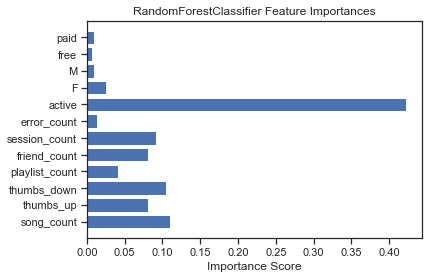

In [179]:
feat_imp = model_rf.featureImportances.values
y_pos = np.arange(len(numericCols))
plt.barh(y_pos, feat_imp, align='center')
plt.yticks(y_pos, numericCols)
plt.xlabel('Importance Score')
plt.title('RandomForestClassifier Feature Importances');

In [149]:
print(feat_imp)

[0.10969803 0.08144803 0.10498219 0.04152964 0.08135222 0.09204245
 0.01403873 0.42193142 0.02589082 0.01005112 0.00711918 0.00991617]


In [160]:
print(model_rf.explainParams())

estimator: estimator to be cross-validated (current: Pipeline_46935b148530)
estimatorParamMaps: estimator param maps (current: [{Param(parent='RandomForestClassifier_37c47851f050', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2, Param(parent='RandomForestClassifier_37c47851f050', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 5, Param(parent='RandomForestClassifier_37c47851f050', name='numTrees', doc='Number of trees to train (>= 1).'): 5}, {Param(parent='RandomForestClassifier_37c47851f050', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2, Param(parent='RandomForestClassifier_37c47851f050', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of cate

In [150]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features")
evaluator = MulticlassClassificationEvaluator()    

pipeline = Pipeline(stages= rf ) 
paramGrid = ParamGridBuilder().addGrid(rf.maxDepth, [2, 5, 10, 20, 30])
                              .addGrid(rf.maxBins, [10, 20, 40, 80, 100])
                              .addGrid(rf.numTrees, [5, 20, 50, 100, 500])
                              .build()

In [151]:
crossval = CrossValidator(estimator = pipeline,         
                          estimatorParamMaps= paramGrid,
                          evaluator = evaluator,
                          numFolds = 5)

In [152]:
model_rf = crossval.fit(train)

In [153]:
predictions = model_rf.transform(test)

In [154]:
predictions.select("prediction", "label").show(5)

+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    1|
|       0.0|    0|
+----------+-----+
only showing top 5 rows



In [168]:
predictions_rf.groupBy('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|    5|
|    0|       1.0|    4|
|    0|       0.0|   52|
|    1|       1.0|    8|
+-----+----------+-----+



In [165]:
evaluatorf1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1 = evaluatorf1.evaluate(predictions)
print("f1 = %g" % f1)

f1 = 0.867534


In [169]:
evaluator_rf =MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction", metricName="accuracy")
accuracy_rf = evaluator_rf.evaluate(predictions_rf)

evaluatorf1_rf = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_rf = evaluatorf1_rf.evaluate(predictions_rf)

evaluatorwp_rf = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
wp_rf = evaluatorwp_rf.evaluate(predictions_rf)

evaluatorwr_rf = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
wr_rf = evaluatorwr_rf.evaluate(predictions_rf)

In [170]:
print ("Random Forest Model Metrics :-")
print("f1 = %g" % f1_rf)
print("accuracy = %g" % accuracy_rf)
print("weightedPrecision = %g" % wp_rf)
print("weightedRecall = %g" % wr_rf)

Random Forest Model Metrics :-
f1 = 0.867534
accuracy = 0.869565
weightedPrecision = 0.866006
weightedRecall = 0.869565


In [156]:
# How many models tested ?
print('Number of models to be tested: ', len(paramGrid))

Number of models to be tested:  27


In [158]:
bestModel = model_rf.bestModel

In [159]:
print(bestModel)

PipelineModel_35def97247ce


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.